
# Explanation of the task:

This is the classic Emotion Recognition Classification task. Given a conversation, involving 2 or more parties, for each message/utterance, we want to predict an emotion related to it.


Consider the example:

**Person A**: "Hello! I am very happy" (happiness)

**Person B**: "Why? I am very angry"   (anger)

## First model idea:
- inputs: sequence of utterances, sequence of emotions.
- For each: Linear Layers
- Fusion model

- Loss: cross-entropy



# Other approach:

Consider the each conversation as just a sequence of words:
$$
[[utt, utt, \cdots], \cdots ] \longrightarrow [[word, word , \cdots], \cdots]
$$

Issue comes when there is some separator: How to implement it? Idea: Use a random token to represent it.

## Weight update:
 - Make the updatable weights constant and then update it dynamically
 - train it once and them update it dynamically in the forward pass
 - cache weight matrices and train them individually -> this does not train properly (super slow convergence)


In [2]:
! pip install nltk
! pip install torch
! pip install pandas
! pip install gensim
! pip install datasets
! pip install matplotlib
! pip install tqdm
! pip install torchinfo
# eventually include tensorboard

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [3]:
# ML resources:
import torch
import os
import matplotlib.pyplot as plt
from datasets import load_dataset
from gensim.models import Word2Vec
from torch.utils.data import Dataset, DataLoader

#others:
import pandas as pd
import numpy as np


punctuation = [".",",","?", "!",";",":","-","_","(",")","[","]","{","}"]


## DataLoader not implemented yet:

In [4]:
## annoying to adapt a bit

class DailyDialogDataset(Dataset):
  def __init__(self, text, emot,text_class,emo_class):
  # Dataset object for Daily Dialog dataset
    self.text = text ## text with embeddings
    self.emot = emot ## emotion with embeddings
    self.text_classes = text_class   ## text for CrossEntropy
    self.emotion_classes = emo_class ## emotions for CrossEntropy

  def __len__(self):
    # this should return the size of the dataset
    return len(self.text)

  def __getitem__(self, idx):
    # this should return one sample from the dataset
    item = {
        'text': self.text[idx],
        'emot': self.emot[idx],
        'text_class': self.text_classes[idx],
        'emotion_class': self.emotion_classes[idx]
    }
    return item



Here we will extract the data:

In [5]:
emotions_emb = {}

data = load_dataset('daily_dialog')
X_train = data['train']['dialog']
Y_train = data['train']['emotion']

X_test = data['test']['dialog']
Y_test = data['test']['emotion']

X_val = data['validation']['dialog']
Y_val = data['validation']['emotion']

bagofwords = []
emotions = []

for lx,ly in zip(X_train,Y_train):
  assert(len(lx) == len(ly))
for lx,ly in zip(X_val,Y_val):
  assert(len(lx) == len(ly))
for lx,ly in zip(X_test,Y_test):
  assert(len(lx) == len(ly))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.27k [00:00<?, ?B/s]

daily_dialog.py:   0%|          | 0.00/4.85k [00:00<?, ?B/s]

The repository for daily_dialog contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/daily_dialog.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/11118 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

While dataloader is not implemented, we have this:

In [6]:
def Preprocess_Data(X_,Y_): ## We do some simple prepocessing
  bagofwords = []
  emotions = []
  X = X_
  Y = Y_
  for i in range(len(X)):
    l1 = []
    l2 = []
    for j in range(len(X[i])):
      to_append = X[i][j].lower().split()
      l1.extend(to_append)
      l2.extend([Y[i][j]]*len(to_append))
      bagofwords.append(to_append)
    X[i] = l1
    Y[i] = l2

  for i in range(len(X)): ## remove puncuation
    to_remove = []
    for j in range(len(X[i])):
      if X[i][j] in punctuation:
        to_remove.append(j)
    for j in to_remove[::-1]:
      X[i].pop(j)
      Y[i].pop(j)
  for i in Y:
    for j in i:
      emotions.append(j)
  emotions = list(set(emotions))

  for lx,ly in zip(X,Y):
    assert(len(lx) == len(ly))
  return X_, Y_, bagofwords, emotions

X_train,Y_train, bagofwords1, emotions = Preprocess_Data(X_train,Y_train)
X_test,Y_test, bagofwords2, _ = Preprocess_Data(X_test,Y_test)
X_val,Y_val, bagofwords3, _ = Preprocess_Data(X_val,Y_val)



In [7]:
for lx,ly in zip(X_train,Y_train):
  assert(len(lx) == len(ly))
for lx,ly in zip(X_val,Y_val):
  assert(len(lx) == len(ly))
for lx,ly in zip(X_test,Y_test):
  assert(len(lx) == len(ly))

print("train size: ",len(X_train))
print("test size: ",len(X_test))
print("validation size: ",len(X_val))
print("emotions: ",emotions)


train size:  11118
test size:  1000
validation size:  1000
emotions:  [0, 1, 2, 3, 4, 5, 6]


Now we train w2v:

In [8]:
word_dim = 100
w2v = Word2Vec(sentences=bagofwords1, vector_size=word_dim, min_count=1)

print("vocabulary size: ",len(w2v.wv))

vocabulary size:  22075


In [10]:
if len(emotions_emb) > 0:
    pass
else:
  emotions_emb = {}

def encode_text(X):
  train_X = []
  words_list = []
  train_X_class = {}
  for dialog in X:
    for word in dialog:
      if word not in words_list:
        words_list.append(word)
      try:
        tens = torch.from_numpy(w2v.wv[word])
        tens = tens.type(torch.float32)
      except:
        tens = torch.rand(word_dim,dtype=torch.float32)
      train_X.append(tens)

  stoi = {word:i for i,word in enumerate(words_list)}
  itos = {i:word for i,word in enumerate(words_list)}
  X_utt = []
  for i,word in itos.items():
    tens = torch.zeros(len(words_list))
    tens[i] = 1
    train_X_class[word] = tens
  for dialog in X:
    X_utt = []
    for word in dialog:
      X_utt.append(train_X_class[word])
  return train_X, stoi, itos, train_X_class,X_utt

## We do something similar to the emotions (but we initialized them randomly)
def encode_emotions(Y,emotions_emb,plot_=False):
  train_Y = []
  plot_data = {i:0 for i in emotions}
  if len(emotions_emb) == 0:
    for emotion in emotions:
      emotions_emb[emotion] = torch.rand(word_dim,dtype=torch.float32)

  for dialog in Y:
    for em in dialog:
      train_Y.append(emotions_emb[em])
    if plot_:
      plot_data[em] += 1
  emotion_class = {}
  for i in emotions:
    ten = torch.zeros(len(emotions))
    ten[i] = 1
    emotion_class[i] = ten
  Y_emo = []
  for j in Y:
    for k in j:
      Y_emo.append(emotion_class[k])
  if plot_:
    plt.plot(emotions,plot_data.values())
  return train_Y, Y_emo, emotion_class

def emotion_to_tensor(Y,emotion_class):
  emotion_tensor = []
  for dialog in Y:
    l = []
    for em in dialog:
      l.append(emotion_class[em])
    emotion_tensor.append(l)
  return torch.stack(emotion_tensor)

## SOME PLOTS ON THE DATA:


X_train1, stoi_train1, itos_train1, train_X_class,X_train_utt = encode_text(X_train)
Y_train1, Y_train_emo, emotion_class = encode_emotions(Y_train,emotions_emb)

X_test1, _, _, test_X_class,  X_test_utt  = encode_text(X_test)
Y_test1, Y_test_emo, _ = encode_emotions(Y_test,emotions_emb)

X_val1, _, _, val_X_class, X_val_utt = encode_text(X_val)
Y_val1, Y_val_emo, _ = encode_emotions(Y_val,emotions_emb)

Data_train = DailyDialogDataset(X_train1,Y_train1,X_train_utt,Y_train_emo)
Data_test = DailyDialogDataset(X_test1,Y_test1,X_test_utt,Y_test_emo)
Data_val = DailyDialogDataset(X_val1,Y_val1,X_val_utt,Y_val_emo)



tensor([0., 0., 0.,  ..., 0., 0., 0.])


In [ ]:
for i, vec in enumerate(train_X_class.values()):
  assert(i == torch.argmax(vec))

print(Y_train_emo[1])
print(Y_train1[1])

tensor([1., 0., 0., 0., 0., 0., 0.])
tensor([0.6620, 0.2431, 0.7484, 0.2356, 0.4688, 0.6588, 0.3464, 0.9082, 0.7184,
        0.0931, 0.8358, 0.2151, 0.3737, 0.1411, 0.8358, 0.2227, 0.2632, 0.2331,
        0.3115, 0.7511, 0.3193, 0.3199, 0.3354, 0.1217, 0.7455, 0.0532, 0.2409,
        0.7805, 0.2804, 0.1881, 0.6033, 0.2690, 0.4191, 0.9855, 0.5164, 0.0492,
        0.3515, 0.9730, 0.1312, 0.0813, 0.7145, 0.3991, 0.2235, 0.5086, 0.5437,
        0.8303, 0.8442, 0.7454, 0.5947, 0.8805, 0.4999, 0.0107, 0.9475, 0.4491,
        0.0665, 0.1047, 0.0436, 0.2785, 0.9698, 0.0280, 0.5739, 0.8803, 0.4555,
        0.0613, 0.1307, 0.9704, 0.7934, 0.3384, 0.6912, 0.2287, 0.4145, 0.7256,
        0.0432, 0.4007, 0.5779, 0.5192, 0.2697, 0.4099, 0.7986, 0.6857, 0.7637,
        0.6483, 0.3161, 0.3097, 0.9696, 0.8398, 0.7648, 0.2919, 0.9544, 0.6948,
        0.9042, 0.4793, 0.1649, 0.3483, 0.1542, 0.1829, 0.4872, 0.8118, 0.5414,
        0.5107])


# The model:
## archtecture
- 2 input channels: word encoding, emotion encoding
- dinamically updated weights: $w_1, w_2 = w1 + w2, w1$ (this is a lie. The weights are cached and trained)
### For each channel:
   - 3 sequential Linear layers
- fusion linear layer through concatenation
- 2 output channels which contain a linear layer each





In [ ]:
import torch.nn as nn
import torch.nn.functional as F
class SimpleModel(nn.Module):
  def __init__(self, n_emb_utt, n_emb_emo, emotions_size, vocab_size,device):
    super(SimpleModel,self).__init__()
    ## Decide size later!
    self.target_dev = device
    self.current_weight = 0
    self.decoder = nn.Linear(n_emb_utt,vocab_size)
    ## Channel for utterances/words:
    self.Linear_utt1 = nn.Linear(n_emb_utt,80)
    self.Linear_utt2 = nn.Linear(80,80)
    self.Linear_utt3 = nn.Linear(80,80)
    self.Linear_utt3.requires_grad = False

    ## Channel for emotions:
    self.Linear_emo1 = nn.Linear(n_emb_utt,80)
    self.Linear_emo2 = nn.Linear(80,80)
    self.Linear_emo3 = nn.Linear(80,80)
    self.Linear_emo3.requires_grad = False
    ## fusion by concatenation and Linear layer:
    self.Linear_fus = nn.Linear(160,300)

    ## We concatenate and do linear again (2 different concatenations)
    self.Linear_utt_final = nn.Linear(380, n_emb_utt)
    self.Linear_emo_final = nn.Linear(380, emotions_size)

    self.softmax = nn.Softmax(dim=0)



  def forward(self, text_emb, emo_emb):

    x = self.Linear_utt1(text_emb)
    x = self.Linear_utt2(x)
    x = self.Linear_utt3(x)

    y = self.Linear_emo1(emo_emb)
    y = self.Linear_emo2(y)
    y = self.Linear_emo3(y)

    z = torch.cat((x,y),-1) ## very simple
    z = self.Linear_fus(z)

    w = torch.cat((z,x),-1)

    pred_token = self.Linear_utt_final(w)
    pred_token = self.decoder(pred_token)
    pred_token = self.softmax(pred_token)

    v = torch.cat((z,y),-1)
    v = self.Linear_emo_final(v)

    pred_emotion = self.softmax(v)
    return pred_token, pred_emotion



In [ ]:
import torch.optim as optim
from tqdm.notebook import tqdm
def activate_gpu(force_cpu=False): # check if gpu available ; code taken from template
    device = "cpu"
    if not force_cpu:
        if torch.cuda.is_available(): # for both Nvidia and AMD GPUs
            device = 'cuda'
            print('DEVICE = ', torch.cuda.get_device_name(0))
        elif torch.backends.mps.is_available(): # for mac ARM chipset
            device = 'mps'
            print('DEVICE = ', "mps" )
        else: # for cpu only
            device = 'cpu'
            print('DEVICE = ', 'CPU', "blue")
    return device

def train(model, epochs, device,train_X, train_Y, train_Y_emo,train_X_utt,batch_size = 50):
  optimizer = optim.Adam(model.parameters())
  loss_fn = nn.CrossEntropyLoss()
  model.train()
  model = model.to(device)
  losses = []
  loss = 0
  for i in emotion_class.keys():
    emotion_class[i] = emotion_class[i].to(device)
  for i in train_X_class.keys():
    train_X_class[i].to(device)

  for epoch in range(epochs):
    optimizer.zero_grad()
    model.zero_grad()
    print(f"Epoch {epoch+1}/{epochs}")
    x_axis = []
    loss_batch = 0
    model.current_weight = 0
    for i in tqdm(range(0,len(train_X),batch_size)):
      loss = 0
      if len(train_Y[i: i- 1 + batch_size]) != len(train_Y_emo[i + 1: i + batch_size]):
        batch_X = torch.stack(train_X[i : - 1]).to(device)
        batch_Y = torch.stack(train_Y[i : - 1]).to(device)
        next_Y  = torch.stack(train_Y_emo[i+1 : i+1+batch_size]).to(device)
      else:
        batch_X = torch.stack(train_X[i : i+batch_size]).to(device)
        batch_Y = torch.stack(train_Y[i : i+batch_size]).to(device)
        next_Y  = torch.stack(train_Y_emo[i+1 : i+1+batch_size]).to(device)

      pt, pe  = model.forward(batch_Y,batch_Y)
      loss = loss_fn(pe,next_Y)
      loss.backward()
      optimizer.step()
      loss_batch += loss.item()
    loss_batch = loss_batch/(len(train_X)//batch_size + 1)
    losses.append(loss_batch)
    print(f"loss: ",loss_batch)
  return losses


In [ ]:
device = activate_gpu()
fn = nn.CrossEntropyLoss()
model = SimpleModel(word_dim,word_dim,len(emotions),len(train_X_class),device)
print(device)

DEVICE =  Tesla T4
cuda


Epoch 1/15


  0%|          | 0/20001 [00:00<?, ?it/s]

loss:  1.9392371356120723
Epoch 2/15


  0%|          | 0/20001 [00:00<?, ?it/s]

loss:  1.939048562584612
Epoch 3/15


  0%|          | 0/20001 [00:00<?, ?it/s]

loss:  1.9389951553328515
Epoch 4/15


  0%|          | 0/20001 [00:00<?, ?it/s]

loss:  1.938977300050908
Epoch 5/15


  0%|          | 0/20001 [00:00<?, ?it/s]

loss:  1.9389781903924956
Epoch 6/15


  0%|          | 0/20001 [00:00<?, ?it/s]

loss:  1.9389915141360319
Epoch 7/15


  0%|          | 0/20001 [00:00<?, ?it/s]

loss:  1.9389755078884525
Epoch 8/15


  0%|          | 0/20001 [00:00<?, ?it/s]

loss:  1.9389226357344775
Epoch 9/15


  0%|          | 0/20001 [00:00<?, ?it/s]

loss:  1.9389202835428603
Epoch 10/15


  0%|          | 0/20001 [00:00<?, ?it/s]

loss:  1.9389613209578473
Epoch 11/15


  0%|          | 0/20001 [00:00<?, ?it/s]

loss:  1.939023595113503
Epoch 12/15


  0%|          | 0/20001 [00:00<?, ?it/s]

loss:  1.9391306206069168
Epoch 13/15


  0%|          | 0/20001 [00:00<?, ?it/s]

loss:  1.9391306206069168
Epoch 14/15


  0%|          | 0/20001 [00:00<?, ?it/s]

loss:  1.9391306206069168
Epoch 15/15


  0%|          | 0/20001 [00:00<?, ?it/s]

loss:  1.9391288207260455


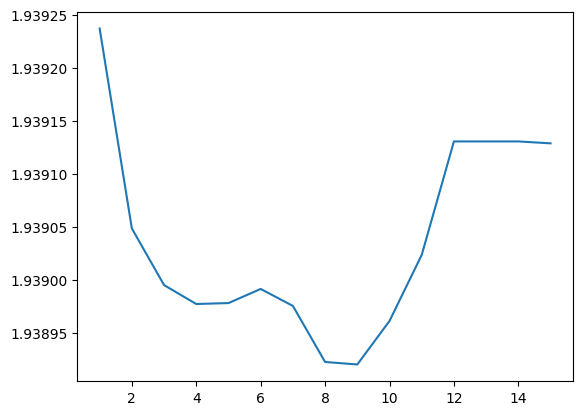

In [ ]:
epochs = 15

losses = train(model,epochs,device,X_train1,Y_train1,Y_train_emo,X_train_utt)
plt.plot(np.arange(1,epochs+1),losses)

# Descrition of the issues faced:

It is not trivial of how to deal with the gradient flow in this case. Maybe by fixing the 2 matrix it would go better. Or just train the matrix with fixed weight. And update the weight not in the forward pass. but in the prediction. this way we can cache the weight and everytime we restart, we will be ok.

I believe that, the issue of this approach specifically is updating directly the weights, and not, a hidden state, for instance.

# Problem with Daily Dialog:
By plotting the frequency of each emotion, we notice that the dataset is truly not diversified. It has essentially only 2 emotions. This is not ideal, because the models will most likely overfit into predicting those 2 emotions...

In [ ]:
def compute_test_loss(model,test_X,test_Y,test_Y_emo,loss_fn,device,batch_size=100):
  model.eval()
  losses = []
  prec = 0
  total = 0
  for i in emotion_class.keys():
    emotion_class[i] = emotion_class[i].to(device)
  for i in train_X_class.keys():
    train_X_class[i].to(device)

  for i in tqdm(range(0,len(test_X),batch_size)):
    loss = 0
    if len(test_Y[i: i- 1 + batch_size]) != len(test_Y_emo[i + 1: i + batch_size]):
      batch_X = torch.stack(test_X[i : - 1]).to(device)
      batch_Y = torch.stack(test_Y[i : - 1]).to(device)
      next_Y  = torch.stack(test_Y_emo[i+1 : i+1+batch_size]).to(device)
    else:
      batch_X = torch.stack(test_X[i : i+batch_size]).to(device)
      batch_Y = torch.stack(test_Y[i : i+batch_size]).to(device)
      next_Y  = torch.stack(test_Y_emo[i+1 : i+1+batch_size]).to(device)

    pt, pe  = model.forward(batch_Y,batch_Y)
    loss = loss_fn(pe,next_Y)
    losses.append(loss.item())
  print("average loss: ", sum(losses)/len(losses))
compute_test_loss(model,X_test1,Y_test1,Y_test_emo,nn.CrossEntropyLoss(),device)


  0%|          | 0/899 [00:00<?, ?it/s]

average loss:  1.9400917029089073
